In [21]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
plt.style.use('fivethirtyeight')

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

In [24]:
data = pd.read_csv('PJM_Load_hourly.csv', index_col=[0], parse_dates=[0])

In [25]:
data = data.sort_index()

In [26]:
#data['PJM_Load_MW_mean_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['PJM_Load_MW_mean_daily'] = data['PJM_Load_MW'].rolling(24).mean()
data['PJM_Load_MW_mean_weekly'] = data['PJM_Load_MW'].rolling(24*7).mean()
data['PJM_Load_MW_mean_monthly'] = data['PJM_Load_MW'].rolling(24*30).mean()

In [27]:
#data['PJM_Load_MW_std_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['PJM_Load_MW_std_daily'] = data['PJM_Load_MW'].rolling(24).std()
data['PJM_Load_MW_std_weekly'] = data['PJM_Load_MW'].rolling(24*7).std()
data['PJM_Load_MW_std_monthly'] = data['PJM_Load_MW'].rolling(24*30).std()

In [28]:
data['date'] = data.index
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek
#data['quarter'] = data['date'].dt.quarter
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year 
data['dayofyear'] = data['date'].dt.dayofyear
data['dayofmonth'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.weekofyear
#data['day_night'] = data['date'].dt.strftime('%B %d, %Y, %r').str[-2:]
#data['is_holiday'] = data['date'].isin([d.date() for d in cal.holidays()])

In [29]:
data = data.drop(columns=['date'])

In [30]:
data.head(10)

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,,,,,
1998-04-01 01:00:00,22259.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2,4,1998,91,1,14
1998-04-01 02:00:00,21244.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4,1998,91,1,14
1998-04-01 03:00:00,20651.0,NaN,NaN,NaN,NaN,NaN,NaN,3,2,4,1998,91,1,14
1998-04-01 04:00:00,20421.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2,4,1998,91,1,14
1998-04-01 05:00:00,20713.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2,4,1998,91,1,14
1998-04-01 06:00:00,22526.0,NaN,NaN,NaN,NaN,NaN,NaN,6,2,4,1998,91,1,14
1998-04-01 07:00:00,25772.0,NaN,NaN,NaN,NaN,NaN,NaN,7,2,4,1998,91,1,14
1998-04-01 08:00:00,28724.0,NaN,NaN,NaN,NaN,NaN,NaN,8,2,4,1998,91,1,14
1998-04-01 09:00:00,30075.0,NaN,NaN,NaN,NaN,NaN,NaN,9,2,4,1998,91,1,14


In [31]:
data['target'] = data['PJM_Load_MW'].shift(-5)

In [32]:
data

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,target
Datetime,,,,,,,,,,,,,,,
1998-04-01 01:00:00,22259.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2,4,1998,91,1,14,22526.0
1998-04-01 02:00:00,21244.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4,1998,91,1,14,25772.0
1998-04-01 03:00:00,20651.0,NaN,NaN,NaN,NaN,NaN,NaN,3,2,4,1998,91,1,14,28724.0
1998-04-01 04:00:00,20421.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2,4,1998,91,1,14,30075.0
1998-04-01 05:00:00,20713.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2,4,1998,91,1,14,30689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 20:00:00,36392.0,32718.750000,31029.851190,29640.298611,3009.060178,3648.132180,4121.390260,20,0,12,2001,365,31,1,NaN
2001-12-31 21:00:00,35082.0,32681.583333,31055.065476,29649.791667,2972.389888,3661.468182,4126.045636,21,0,12,2001,365,31,1,NaN
2001-12-31 22:00:00,33890.0,32636.208333,31074.839286,29659.000000,2943.970049,3667.786829,4128.102546,22,0,12,2001,365,31,1,NaN


In [33]:
data.dropna(axis=0, how='any', inplace=True)

In [35]:


split_date = '31-12-1999'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()



In [36]:
X_train = data_train.drop(columns=['target','year','month'])
X_test = data_test.drop(columns=['target','year','month'])
y_train = data_train[['target']]
y_test = data_test[['target']]

In [37]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:21128.38477	validation_1-rmse:21657.93164
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:14882.31738	validation_1-rmse:15330.00586
[2]	validation_0-rmse:10519.58496	validation_1-rmse:10902.10254
[3]	validation_0-rmse:7486.73535	validation_1-rmse:7841.67188
[4]	validation_0-rmse:5385.09668	validation_1-rmse:5720.71631
[5]	validation_0-rmse:3952.22412	validation_1-rmse:4279.01172
[6]	validation_0-rmse:2986.51294	validation_1-rmse:3314.32788
[7]	validation_0-rmse:2333.27759	validation_1-rmse:2671.89551
[8]	validation_0-rmse:1923.21899	validation_1-rmse:2285.82935
[9]	validation_0-rmse:1643.71777	validation_1-rmse:2013.79187
[10]	validation_0-rmse:1471.96326	validation_1-rmse:1856.53943
[11]	validation_0-rmse:1371.80591	validation_1-rmse:1769.30798
[12]	validation_0-rmse:1307.07654	validation_1-rmse:1727.25342
[13]	validation_0-rmse:125

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [38]:
pyplot.rcParams["figure.figsize"] = (20,10)

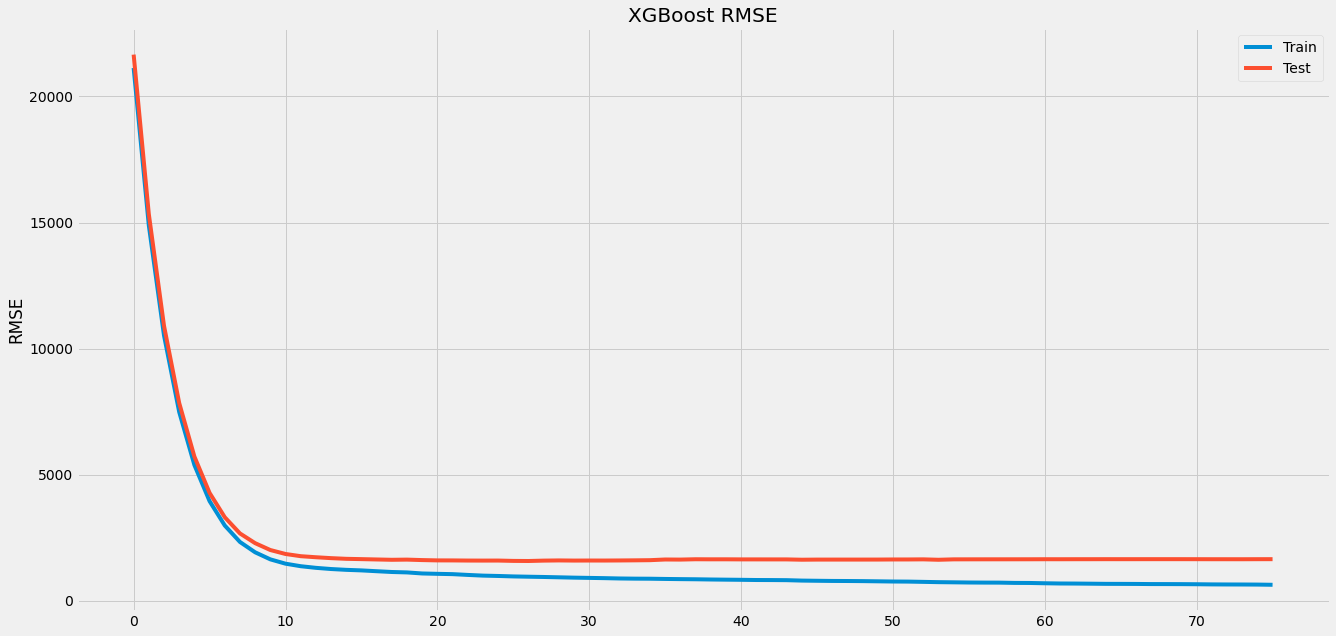

In [39]:

# retrieve performance metrics
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

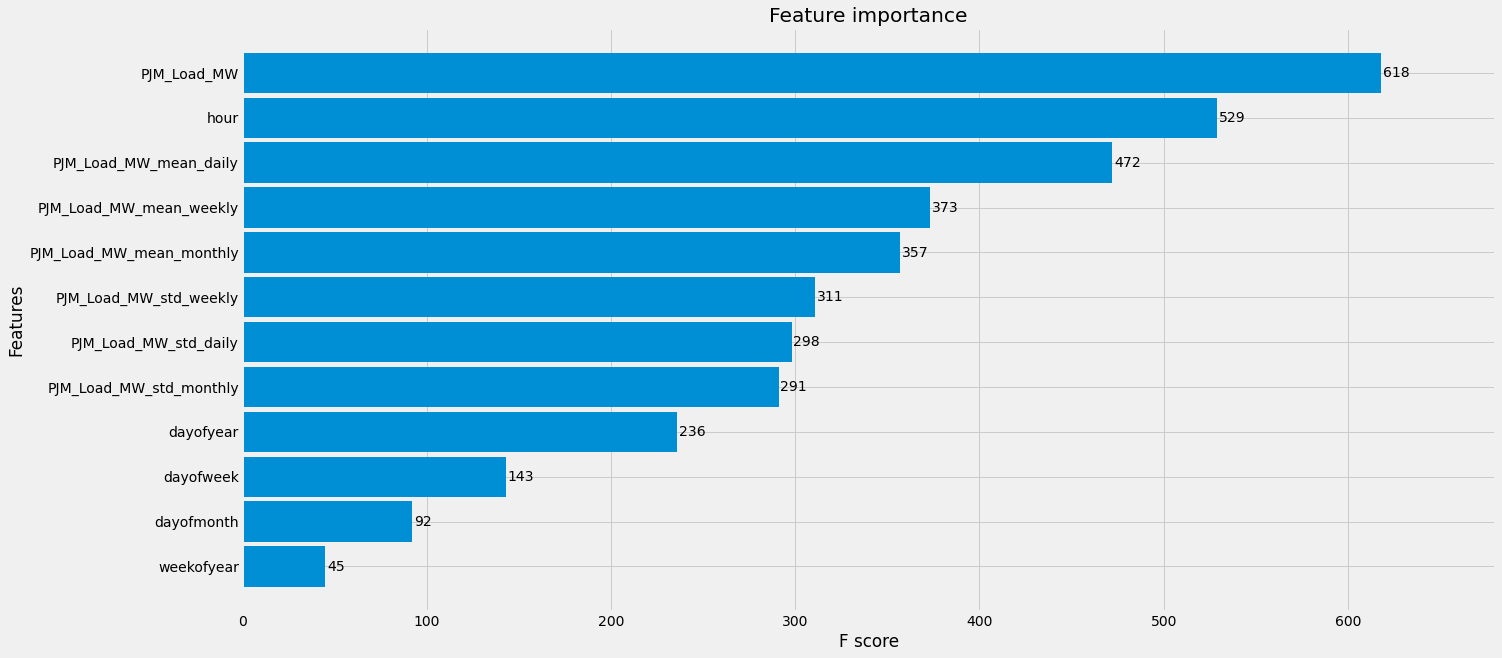

In [40]:
_ = plot_importance(reg, height=0.9)

In [173]:
X_test

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,,,
1999-12-31 01:00:00,24492.0,29776.791667,30771.851190,30017.163889,2950.280517,3386.484652,4172.416045,1,4,365,31,52
1999-12-31 02:00:00,22946.0,29648.666667,30751.583333,30011.352778,3178.428155,3423.093013,4179.350580,2,4,365,31,52
1999-12-31 03:00:00,22533.0,29526.208333,30731.666667,30005.498611,3395.544331,3461.135710,4186.873314,3,4,365,31,52
1999-12-31 04:00:00,22329.0,29406.291667,30711.785714,29999.215278,3599.412494,3499.767057,4194.997669,4,4,365,31,52
1999-12-31 05:00:00,22465.0,29276.958333,30690.547619,29992.333333,3793.804956,3538.936847,4203.290959,5,4,365,31,52
...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 15:00:00,31941.0,32471.791667,30886.208333,29589.538889,2865.271957,3560.621129,4093.169731,15,0,365,31,1
2001-12-31 16:00:00,31759.0,32535.291667,30911.059524,29598.201389,2830.217989,3551.994669,4091.148779,16,0,365,31,1
2001-12-31 17:00:00,33587.0,32602.208333,30937.732143,29607.833333,2835.523584,3555.181881,4092.366264,17,0,365,31,1


In [42]:
#persistance error

In [43]:
mean_squared_error(y_true=data_test['PJM_Load_MW'],y_pred=data_test['MW_Prediction'])

30483866.3359838

In [44]:
mean_absolute_error(y_true=data_test['PJM_Load_MW'],y_pred=data_test['MW_Prediction'])

4422.525243687354

In [45]:
mean_absolute_percentage_error(y_true=data_test['PJM_Load_MW'],y_pred=data_test['MW_Prediction'])

15.278173582442106

In [46]:
#predictions error 

In [47]:
mean_squared_error(y_true=data_test['target'],y_pred=data_test['MW_Prediction'])

2491663.953385091

In [48]:
mean_absolute_error(y_true=data_test['target'],y_pred=data_test['MW_Prediction'])

1136.50991434236

In [49]:
mean_absolute_percentage_error(y_true=data_test['target'],y_pred=data_test['MW_Prediction'])

3.6739215849622164

In [50]:
data_test['error'] = data_test['target'] - data_test['MW_Prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['target','MW_Prediction','error','abs_error']]

In [51]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(20)

target  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2000 6     3           26445.041667   30750.351562 -4305.309408  4305.309408
     7     19          30283.666667   33849.023438 -3565.357422  3739.976074
2001 9     1           29106.958333   31989.212891 -2882.255290  2888.151449
     11    22          24753.875000   27424.673828 -2670.798747  3370.698649
2000 6     13          29479.541667   31889.751953 -2410.210531  2653.950602
2001 5     28          23556.333333   25943.109375 -2386.775309  2690.066325
2000 5     29          22638.625000   24964.988281 -2326.363851  2716.383382
2001 7     2           28495.166667   30754.753906 -2259.587646  2342.758057
2000 7     11          34255.208333   36433.316406 -2178.106364  2202.956136
     6     12          35993.958333   38139.695312 -2145.736979  2230.886719
2001 5     5           26445.666667   28524.898438 -2079.232503  2096.452393
     7     1           33254.833333   35273.339844 -2018.506348  2084.930013
2000 11    23          28447.416667   30347.671875 -1900.255127  3475.260498
     5     15          27046.666667   28861.564453 -1814.897624  1909.538249
2001 7     18          34885.083333   36681.597656 -1796.515137  1916.589518
     9     2           24748.375000   26522.533203 -1774.158854  1774.158854
     12    24          27784.708333   29517.060547 -1732.352865  2543.485026
     9     5           31508.666667   33220.621094 -1711.955160  1753.534261
2000 5     10          31256.083333   32933.183594 -1677.099365  1852.146891
2001 9     25          29115.750000   30758.667969 -1642.918864  1768.918538

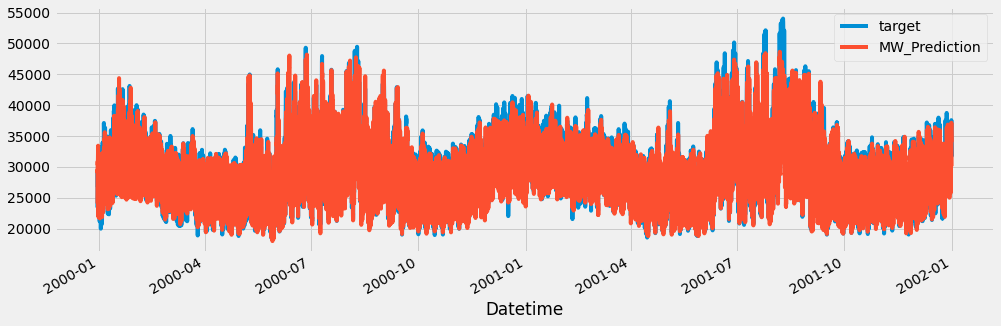

In [52]:
_ = data_test[['target','MW_Prediction']].plot(figsize=(15, 5))

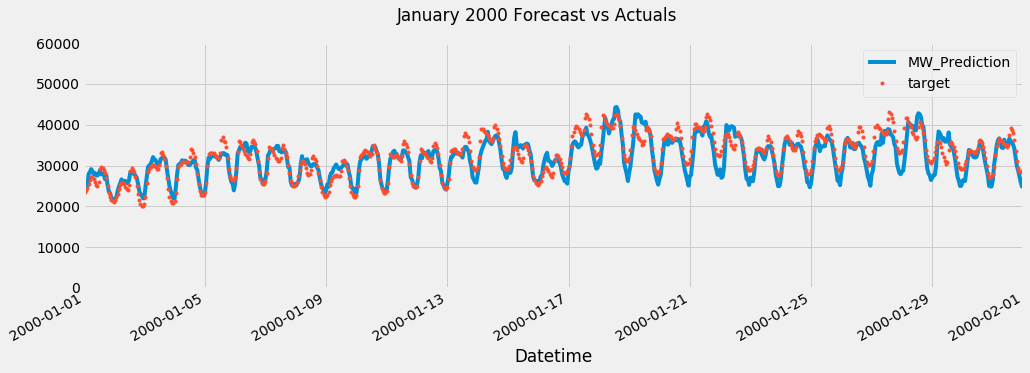

In [358]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2000', upper='02-01-2000')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2000 Forecast vs Actuals')

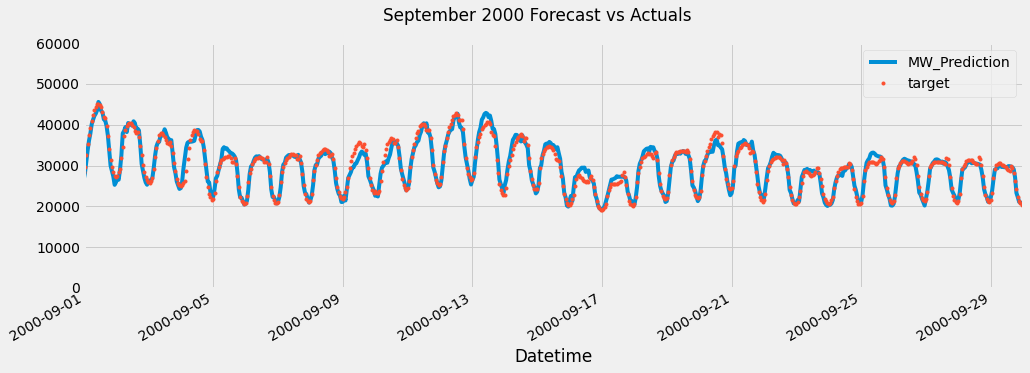

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='09-01-2000', upper='09-30-2000')
ax.set_ylim(0, 60000)
plot = plt.suptitle('September 2000 Forecast vs Actuals')

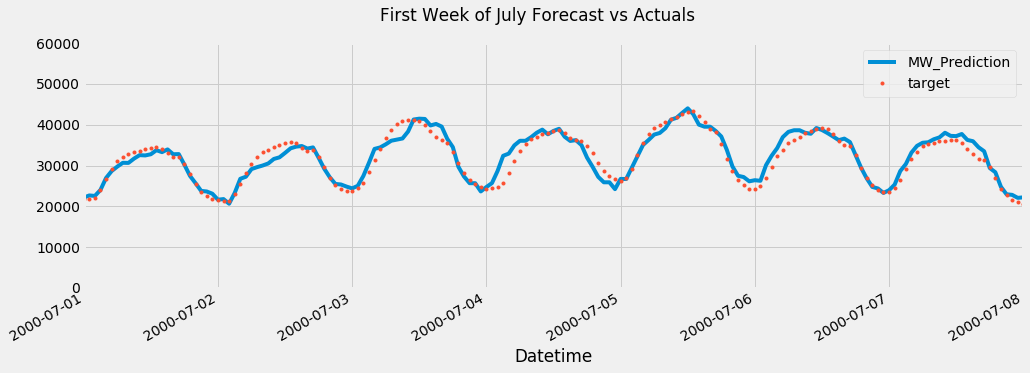

In [359]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2000', upper='07-08-2000')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## standardized data

In [129]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

new_total_data_set = data
total_training_x = new_total_data_set["PJM_Load_MW"]
std.fit(np.array(total_training_x).reshape(-1,1))
new_total_data_set = std.transform(new_total_data_set)
new_total_data_set = pd.DataFrame(new_total_data_set,columns = data.columns,index=data.index)
##spliting


split_date = '31-12-1999'
standardized_data_train = new_total_data_set.loc[new_total_data_set.index <= split_date].copy()
standardized_data_test = new_total_data_set.loc[new_total_data_set.index > split_date].copy()


###dropping and final preprocessing

standardized_X_train = standardized_data_train.drop(columns=['target','year','month'])
standardized_X_test = standardized_data_test.drop(columns=['target','year','month'])
standardized_y_train = standardized_data_train[['target']]
standardized_y_test = standardized_data_test[['target']]

In [130]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(standardized_X_train, standardized_y_train,
        eval_set=[(standardized_X_train, standardized_y_train), (standardized_X_test, standardized_y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:0.86569	validation_1-rmse:0.79376
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.65773	validation_1-rmse:0.61300
[2]	validation_0-rmse:0.51370	validation_1-rmse:0.49256
[3]	validation_0-rmse:0.41819	validation_1-rmse:0.41766
[4]	validation_0-rmse:0.35548	validation_1-rmse:0.37081
[5]	validation_0-rmse:0.31421	validation_1-rmse:0.34244
[6]	validation_0-rmse:0.28748	validation_1-rmse:0.32877
[7]	validation_0-rmse:0.26223	validation_1-rmse:0.30966
[8]	validation_0-rmse:0.24590	validation_1-rmse:0.29771
[9]	validation_0-rmse:0.23644	validation_1-rmse:0.29103
[10]	validation_0-rmse:0.23021	validation_1-rmse:0.28995
[11]	validation_0-rmse:0.22482	validation_1-rmse:0.28721
[12]	validation_0-rmse:0.21629	validation_1-rmse:0.28319
[13]	validation_0-rmse:0.20954	validation_1-rmse:0.27889
[14]	validation_0-rmse:0.20593	validation_1-rmse:0.27

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [131]:
pyplot.rcParams["figure.figsize"] = (20,10)

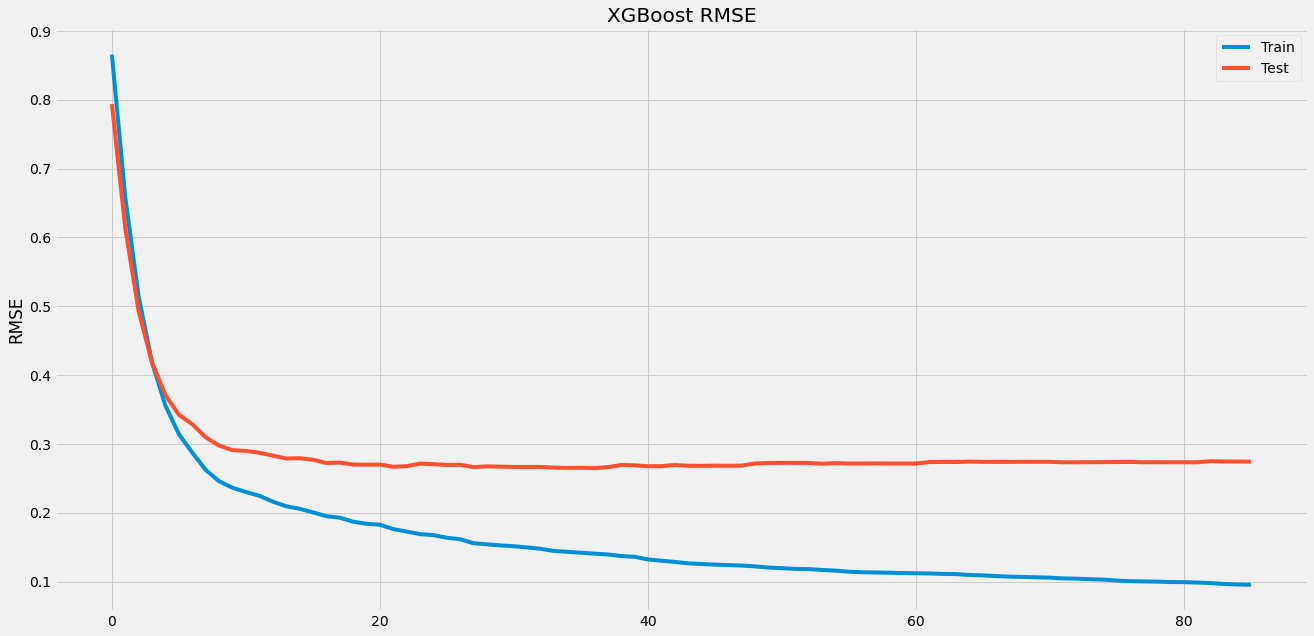

In [132]:
# retrieve performance metrics
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

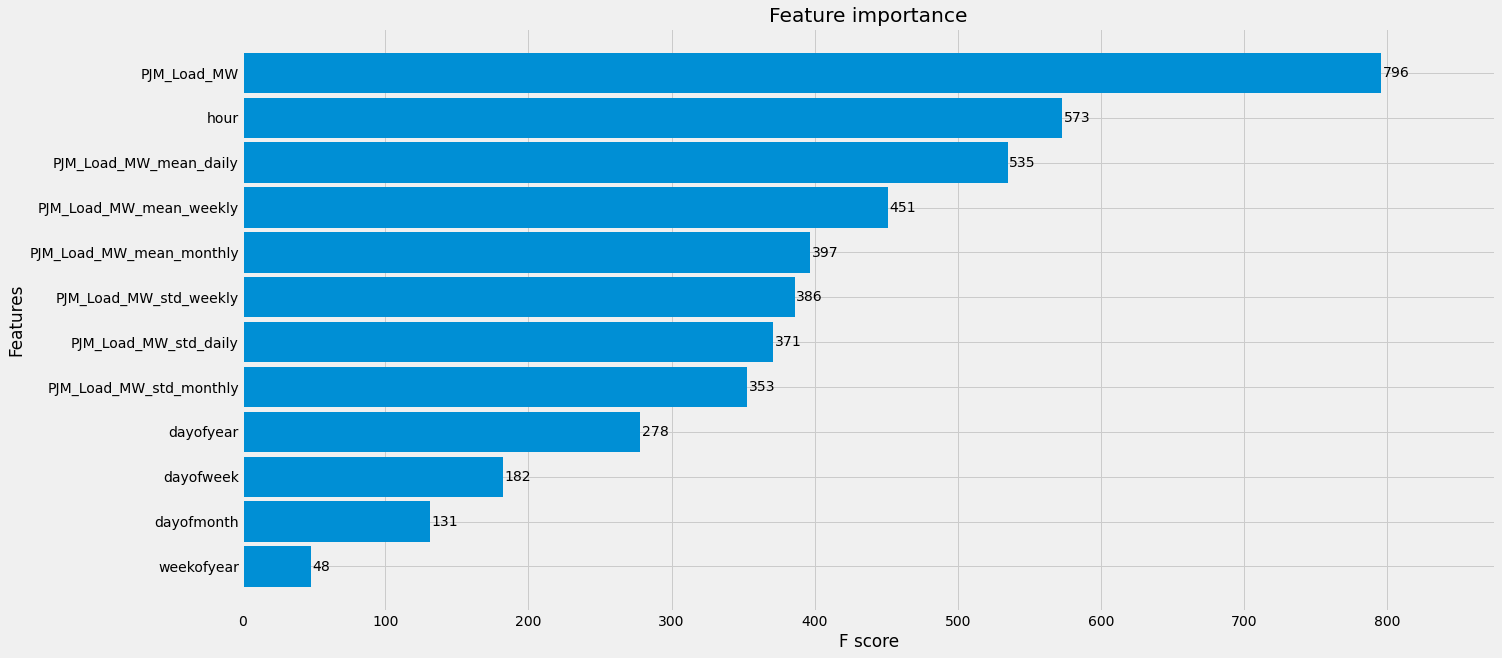

In [133]:
_ = plot_importance(reg, height=0.9)

In [172]:
standardized_data_test

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,target,MW_Prediction
Datetime,,,,,,,,,,,,,,,,
1999-12-31 01:00:00,-0.917758,-0.014692,0.155343,0.026383,-4.598807,-4.524268,-4.389968,-5.102780,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-1.102821,0.948605
1999-12-31 02:00:00,-1.181938,-0.036586,0.151880,0.025390,-4.559821,-4.518013,-4.388783,-5.102609,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.879822,0.948605
1999-12-31 03:00:00,-1.252512,-0.057512,0.148477,0.024389,-4.522720,-4.511512,-4.387498,-5.102438,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.659729,0.948605
1999-12-31 04:00:00,-1.287371,-0.078003,0.145080,0.023315,-4.487883,-4.504911,-4.386110,-5.102267,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.412294,0.948605
1999-12-31 05:00:00,-1.264131,-0.100104,0.141450,0.022139,-4.454665,-4.498217,-4.384693,-5.102097,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.172208,0.948605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 15:00:00,0.355128,0.445829,0.174885,-0.046690,-4.613333,-4.494512,-4.403510,-5.100388,-5.102951,-5.1009,-4.761020,-5.04058,-5.097654,-5.102780,1.115715,0.948605
2001-12-31 16:00:00,0.324028,0.456680,0.179131,-0.045210,-4.619323,-4.495986,-4.403855,-5.100217,-5.102951,-5.1009,-4.761020,-5.04058,-5.097654,-5.102780,0.891862,0.948605
2001-12-31 17:00:00,0.636396,0.468115,0.183689,-0.043564,-4.618417,-4.495441,-4.403647,-5.100046,-5.102951,-5.1009,-4.761020,-5.04058,-5.097654,-5.102780,0.688173,0.948605


In [174]:
standardized_data_test['MW_Prediction'] = reg.predict(standardized_X_test)
standardized_data_all = pd.concat([standardized_data_test, standardized_data_train], sort=False)

In [175]:
standardized_data_test

,PJM_Load_MW,PJM_Load_MW_mean_daily,PJM_Load_MW_mean_weekly,PJM_Load_MW_mean_monthly,PJM_Load_MW_std_daily,PJM_Load_MW_std_weekly,PJM_Load_MW_std_monthly,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,target,MW_Prediction
Datetime,,,,,,,,,,,,,,,,
1999-12-31 01:00:00,-0.917758,-0.014692,0.155343,0.026383,-4.598807,-4.524268,-4.389968,-5.102780,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-1.102821,-1.025409
1999-12-31 02:00:00,-1.181938,-0.036586,0.151880,0.025390,-4.559821,-4.518013,-4.388783,-5.102609,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.879822,-0.343977
1999-12-31 03:00:00,-1.252512,-0.057512,0.148477,0.024389,-4.522720,-4.511512,-4.387498,-5.102438,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.659729,0.167944
1999-12-31 04:00:00,-1.287371,-0.078003,0.145080,0.023315,-4.487883,-4.504911,-4.386110,-5.102267,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.412294,0.221593
1999-12-31 05:00:00,-1.264131,-0.100104,0.141450,0.022139,-4.454665,-4.498217,-4.384693,-5.102097,-5.102267,-5.1009,-4.761362,-5.04058,-5.097654,-5.094065,-0.172208,0.188807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 15:00:00,0.355128,0.445829,0.174885,-0.046690,-4.613333,-4.494512,-4.403510,-5.100388,-5.102951,-5.1009,-4.761020,-5.04058,-5.097654,-5.102780,1.115715,1.240020
2001-12-31 16:00:00,0.324028,0.456680,0.179131,-0.045210,-4.619323,-4.495986,-4.403855,-5.100217,-5.102951,-5.1009,-4.761020,-5.04058,-5.097654,-5.102780,0.891862,1.070498
2001-12-31 17:00:00,0.636396,0.468115,0.183689,-0.043564,-4.618417,-4.495441,-4.403647,-5.100046,-5.102951,-5.1009,-4.761020,-5.04058,-5.097654,-5.102780,0.688173,0.916049


In [176]:
test_x = std.inverse_transform(standardized_data_test['PJM_Load_MW'])
test_lead_time =std.inverse_transform(standardized_data_test['MW_Prediction'])
test_hat_y = std.inverse_transform(standardized_data_test['target'])

In [179]:
mean_absolute_error(y_true=test_x,y_pred=test_lead_time)

4469.020411429858

In [180]:
mean_absolute_percentage_error(y_true=test_x,y_pred=test_lead_time)

15.423947553191955

In [181]:
#predictions error 

In [182]:
mean_squared_error(y_true=test_hat_y,y_pred=test_x)

31414702.29158836

In [183]:
mean_absolute_error(y_true=test_hat_y,y_pred=test_x)

4528.440116179737

In [184]:
mean_absolute_percentage_error(y_true=test_hat_y,y_pred=test_x)

15.638454241227532

In [185]:
plot_testset_dataframe = pd.DataFrame(std.inverse_transform(standardized_data_test[['MW_Prediction','target']]),
                                      index = standardized_data_test.index,columns=['MW_Prediction','target'])

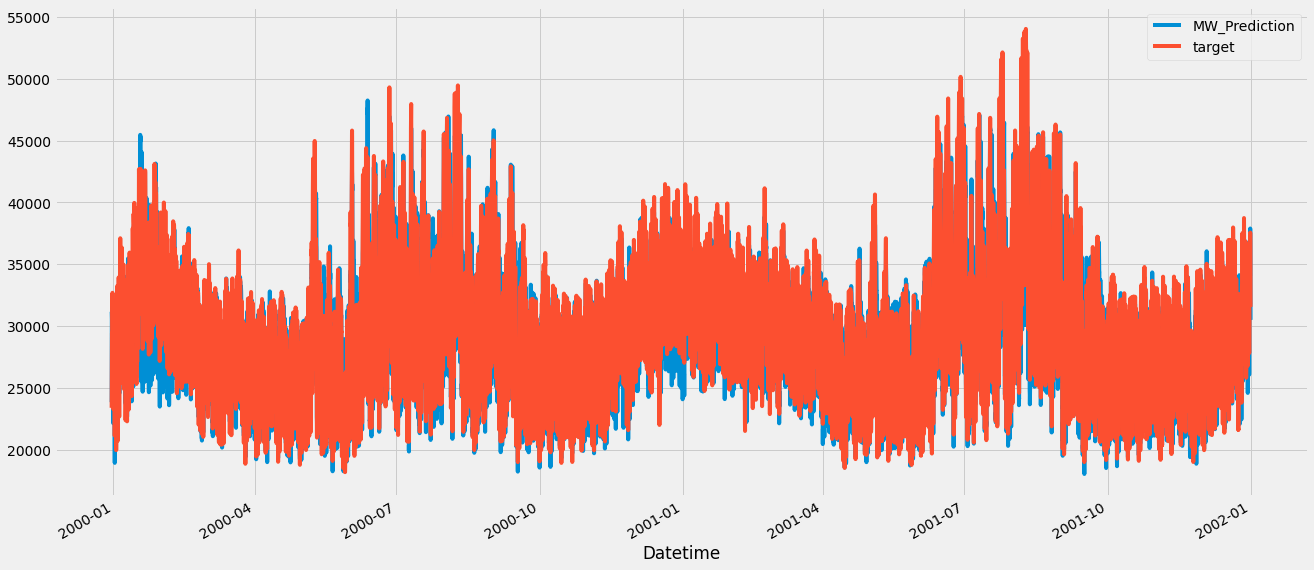

In [187]:
plot_testset_dataframe[['MW_Prediction','target']].plot()

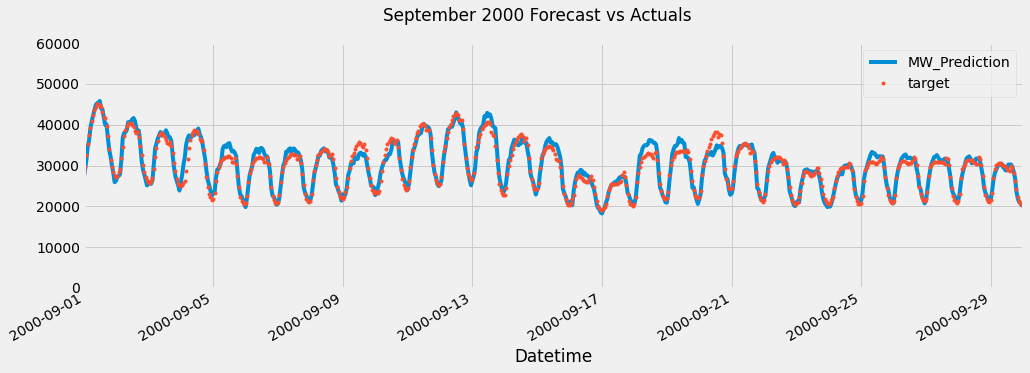

In [188]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ =plot_testset_dataframe[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='09-01-2000', upper='09-30-2000')
ax.set_ylim(0, 60000)
plot = plt.suptitle('September 2000 Forecast vs Actuals')

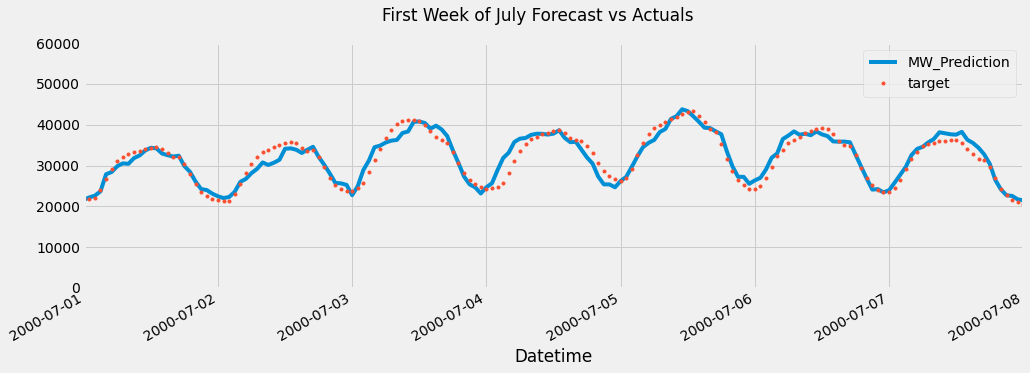

In [190]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = plot_testset_dataframe[['MW_Prediction','target']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2000', upper='07-08-2000')
plot = plt.suptitle('First Week of July Forecast vs Actuals')